In [1]:
!pip install -U albumentations
!pip install ttach

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.1)


In [2]:
!git clone "https://github.com/jacobgil/pytorch-grad-cam.git"
!git clone "https://github.com/vvshankar78/DeepLearning.git"

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.
fatal: destination path 'DeepLearning' already exists and is not an empty directory.


In [3]:
import sys, os

# /content/DeepLearning/Extensive VisionAI-EVA6/
my_path = 'DeepLearning/Extensive VisionAI-EVA6/09_Custom_Resnet'
sys.path.append(my_path)
# os.listdir(my_path)

my_path_cam = '/content/pytorch-grad-cam'
sys.path.append(my_path_cam)

In [4]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [6]:
# from model import Net2
from models import Resnet
from models import my_model
from train import train
from test1 import test
from config import ModelConfig
from utils import *
from data.data_engine import DataEngine

In [7]:
# View model config
args = ModelConfig()
args.dropout_value = 0.0
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 512,
  'batch_size_cuda': 512,
  'dropout_value': 0.0,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


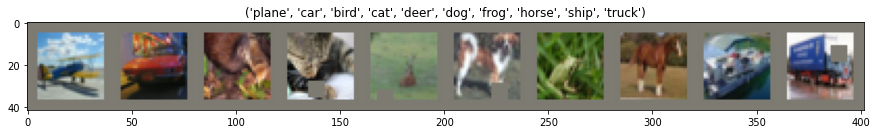

In [8]:
data = DataEngine(args)
data.show_samples()

In [9]:
train_loader = data.train_loader
test_loader = data.test_loader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

CUDA Available? True


In [10]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([512, 3, 38, 38])

In [11]:


# class Net2(nn.Module):


#     def ResBlock(self, in_features, out_features, pading=1):
#       # convolution
#       layers = []

#       layers = [nn.Conv2d(in_features, out_features, 3, padding=pading, bias=False),nn.BatchNorm2d(out_features), nn.ReLU(),
#                 nn.Conv2d(out_features, out_features, 3, padding=pading, bias=False),nn.BatchNorm2d(out_features), nn.ReLU()]

#       return nn.Sequential(*layers)

#     def max_pool_block(self):
#         pool = nn.MaxPool2d(2,2) # output_size = 13
#         return pool

#     def __init__(self):
#         super(Net2, self).__init__()
#         self.convblock1 = self.ResBlock(3,16) #38
#         self.pool1 = self.max_pool_block()  #12
        
#         self.convblock2 = self.ResBlock(16,16) #19
#         self.pool2 = self.max_pool_block()  #9

#         self.convblock3= self.ResBlock(16,16) #9
#         self.pool3 = self.max_pool_block()  #4


#         self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4)) # output_size = 1
#         self.fc1 = nn.Linear(16, 10)

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.pool1(x)
#         x = self.convblock2(x)
#         x = self.pool2(x)
#         x = self.convblock3(x)
#         x = self.pool3(x)

#         x = self.gap(x)
#         x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
#         x = self.fc1(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

# # temp = Net2("BN", input_img_size=(3, 28, 28), num_groups=2).to(device)
# # summary(temp, input_size=(1, 28, 28))

In [12]:


class Net2(nn.Module):


    def ResBlock(self, in_features, out_features, pading=1):
      # convolution
      layers = []
      layers = [nn.Conv2d(in_features, out_features, 3, padding=pading, bias=False),nn.BatchNorm2d(out_features), nn.ReLU(),
                nn.Conv2d(out_features, out_features, 3, padding=pading, bias=False),nn.BatchNorm2d(out_features), nn.ReLU()]
      return nn.Sequential(*layers)

    def max_pool_block(self, in_features, out_features, pading=1):
        layers = []
        layers = [nn.Conv2d(in_features, out_features, 3, padding=pading, bias=False), nn.MaxPool2d(2,2), nn.BatchNorm2d(out_features), nn.ReLU()]
        return nn.Sequential(*layers)


    def __init__(self):
        super(Net2, self).__init__()
        self.convblock0 = nn.Sequential(nn.Conv2d(3,64, 3, padding=1, bias=False),nn.BatchNorm2d(64), nn.ReLU()) #38
        self.pool1 = self.max_pool_block(64,128)  #19
        self.convblock1 = self.ResBlock(128,128) #19
        self.pool2 = self.max_pool_block(128,256)  #9   
        self.pool3 = self.max_pool_block(256,512)  #4             
        self.convblock2 = self.ResBlock(512,512) #4
        

        # self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4)) # output_size = 1
        self.max_pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.convblock0(x)
        x = self.pool1(x)
        x1 = self.convblock1(x)
        x = x+ x1
        x = self.pool2(x)
        x = self.pool3(x)
        x2 = self.convblock2(x)
        x = x + x2

        
        # print(x.shape)
        # x = self.gap(x)
        x = self.max_pool(x)
        # print(x.shape)
        x = x.view(-1,512)
        x = self.fc1(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)


In [13]:
model = Net2().to(device)

In [14]:
model

Net2(
  (convblock0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): Sequential(
    (0): Conv2d(128, 

In [15]:
summary(model, input_size=(3, 38, 38))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 38, 38]           1,728
       BatchNorm2d-2           [-1, 64, 38, 38]             128
              ReLU-3           [-1, 64, 38, 38]               0
            Conv2d-4          [-1, 128, 38, 38]          73,728
         MaxPool2d-5          [-1, 128, 19, 19]               0
       BatchNorm2d-6          [-1, 128, 19, 19]             256
              ReLU-7          [-1, 128, 19, 19]               0
            Conv2d-8          [-1, 128, 19, 19]         147,456
       BatchNorm2d-9          [-1, 128, 19, 19]             256
             ReLU-10          [-1, 128, 19, 19]               0
           Conv2d-11          [-1, 128, 19, 19]         147,456
      BatchNorm2d-12          [-1, 128, 19, 19]             256
             ReLU-13          [-1, 128, 19, 19]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
pip install torch-lr-finder


In [23]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.85E-02


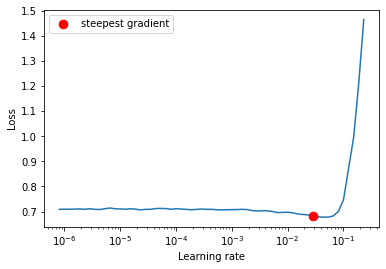

(<matplotlib.axes._subplots.AxesSubplot at 0x7f56f24572d0>,
 0.028480358684358022)

In [21]:

lr_finder.plot()

In [24]:
len(train_loader)

98

In [23]:
len(train_loader)

98

In [24]:
5/24

0.20833333333333334

In [21]:
490/(24*98)

0.20833333333333334

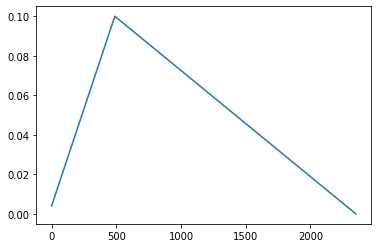

In [25]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
peak = 5 # epoch you want the max lr. 
EPOCHS = 24
peak_pct = peak/EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=98, epochs=24,pct_start=peak_pct, anneal_strategy='linear')
lrs = []


for i in range(24*98):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)

In [16]:
# Input parameters for the model
EPOCHS = 24
l1_decay=0.000
l2_decay=0.0
peak = 5 # epoch you want the max lr. 
EPOCHS = 24
peak_pct = peak/EPOCHS

lrs = []

# model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=peak_pct, 
                                                anneal_strategy='linear')

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list, scheduler)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    # scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Resnet18'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.7871805429458618 Batch_id=97 Accuracy=38.93: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]

length of Average loss 98, length of Average accuracy 98

learning rate 0.023239263803680982



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 4766/10000 (47.66%)

EPOCH: 2


Loss=1.1202328205108643 Batch_id=97 Accuracy=56.94: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]

length of Average loss 196, length of Average accuracy 196

learning rate 0.04247852760736197



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0027, Accuracy: 6230/10000 (62.30%)

EPOCH: 3


Loss=1.098379373550415 Batch_id=97 Accuracy=64.28: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]

length of Average loss 294, length of Average accuracy 294

learning rate 0.061717791411042944



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0019, Accuracy: 7008/10000 (70.08%)

EPOCH: 4


Loss=0.7010316848754883 Batch_id=97 Accuracy=70.90: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]

length of Average loss 392, length of Average accuracy 392

learning rate 0.08095705521472393



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0022, Accuracy: 6532/10000 (65.32%)

EPOCH: 5


Loss=0.693261444568634 Batch_id=97 Accuracy=78.25: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]

length of Average loss 490, length of Average accuracy 490

learning rate 0.09994629452201934



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0021, Accuracy: 7243/10000 (72.43%)

EPOCH: 6


Loss=0.4468925893306732 Batch_id=97 Accuracy=82.69: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]

length of Average loss 588, length of Average accuracy 588

learning rate 0.09468315767991407



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7927/10000 (79.27%)

EPOCH: 7


Loss=0.7030162215232849 Batch_id=97 Accuracy=87.09: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]

length of Average loss 686, length of Average accuracy 686

learning rate 0.08942002083780881



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0019, Accuracy: 7756/10000 (77.56%)

EPOCH: 8


Loss=0.2570262551307678 Batch_id=97 Accuracy=90.67: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]

length of Average loss 784, length of Average accuracy 784

learning rate 0.08415688399570355



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 8068/10000 (80.68%)

EPOCH: 9


Loss=0.1867191046476364 Batch_id=97 Accuracy=93.88: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]

length of Average loss 882, length of Average accuracy 882

learning rate 0.07889374715359829



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8375/10000 (83.75%)

EPOCH: 10


Loss=0.1178678646683693 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]

length of Average loss 980, length of Average accuracy 980

learning rate 0.07363061031149301



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 8249/10000 (82.49%)

EPOCH: 11


Loss=0.10550696402788162 Batch_id=97 Accuracy=97.34: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]

length of Average loss 1078, length of Average accuracy 1078

learning rate 0.06836747346938776



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 8473/10000 (84.73%)

EPOCH: 12


Loss=0.061883535236120224 Batch_id=97 Accuracy=97.88: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]

length of Average loss 1176, length of Average accuracy 1176

learning rate 0.06310433662728249



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 8413/10000 (84.13%)

EPOCH: 13


Loss=0.05602535605430603 Batch_id=97 Accuracy=98.57: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]

length of Average loss 1274, length of Average accuracy 1274

learning rate 0.05784119978517723



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 71 %
Accuracy of   car : 100 %
Accuracy of  bird : 77 %
Accuracy of   cat : 75 %
Accuracy of  deer : 85 %
Accuracy of   dog : 70 %
Accuracy of  frog : 77 %
Accuracy of horse : 77 %
Accuracy of  ship : 80 %
Accuracy of truck : 81 %

Test set: Average loss: 0.0013, Accuracy: 8556/10000 (85.56%)

EPOCH: 14


Loss=0.038837309926748276 Batch_id=97 Accuracy=98.56: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]

length of Average loss 1372, length of Average accuracy 1372

learning rate 0.05257806294307197



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 83 %
Accuracy of  deer : 100 %
Accuracy of   dog : 90 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0013, Accuracy: 8584/10000 (85.84%)

EPOCH: 15


Loss=0.018182365223765373 Batch_id=97 Accuracy=99.10: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]

length of Average loss 1470, length of Average accuracy 1470

learning rate 0.0473149261009667



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 100 %
Accuracy of  bird : 80 %
Accuracy of   cat : 85 %
Accuracy of  deer : 60 %
Accuracy of   dog : 80 %
Accuracy of  frog : 83 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 80 %

Test set: Average loss: 0.0013, Accuracy: 8563/10000 (85.63%)

EPOCH: 16


Loss=0.018012765794992447 Batch_id=97 Accuracy=99.20: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]

length of Average loss 1568, length of Average accuracy 1568

learning rate 0.042051789258861445



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 93 %
Accuracy of   cat : 44 %
Accuracy of  deer : 66 %
Accuracy of   dog : 66 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 66 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8624/10000 (86.24%)

EPOCH: 17


Loss=0.02886877954006195 Batch_id=97 Accuracy=99.40: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]

length of Average loss 1666, length of Average accuracy 1666

learning rate 0.036788652416756176



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 87 %
Accuracy of  bird : 100 %
Accuracy of   cat : 50 %
Accuracy of  deer : 88 %
Accuracy of   dog : 80 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 87 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8704/10000 (87.04%)

EPOCH: 18


Loss=0.008435836061835289 Batch_id=97 Accuracy=99.56: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]

length of Average loss 1764, length of Average accuracy 1764

learning rate 0.031525515574650914



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 60 %
Accuracy of   car : 81 %
Accuracy of  bird : 88 %
Accuracy of   cat : 62 %
Accuracy of  deer : 75 %
Accuracy of   dog : 71 %
Accuracy of  frog : 83 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0013, Accuracy: 8625/10000 (86.25%)

EPOCH: 19


Loss=0.020803680643439293 Batch_id=97 Accuracy=99.58: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]

length of Average loss 1862, length of Average accuracy 1862

learning rate 0.026262378732545652



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 83 %
Accuracy of   cat : 33 %
Accuracy of  deer : 100 %
Accuracy of   dog : 60 %
Accuracy of  frog : 92 %
Accuracy of horse : 100 %
Accuracy of  ship : 66 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0013, Accuracy: 8693/10000 (86.93%)

EPOCH: 20


Loss=0.014872020110487938 Batch_id=97 Accuracy=99.69: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]

length of Average loss 1960, length of Average accuracy 1960

learning rate 0.020999241890440376



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 50 %
Accuracy of  deer : 88 %
Accuracy of   dog : 75 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 81 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0012, Accuracy: 8786/10000 (87.86%)

EPOCH: 21


Loss=0.011405299417674541 Batch_id=97 Accuracy=99.73: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]

length of Average loss 2058, length of Average accuracy 2058

learning rate 0.015736105048335128



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 87 %
Accuracy of  deer : 82 %
Accuracy of   dog : 100 %
Accuracy of  frog : 80 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8797/10000 (87.97%)

EPOCH: 22


Loss=0.005953368730843067 Batch_id=97 Accuracy=99.76: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]

length of Average loss 2156, length of Average accuracy 2156

learning rate 0.010472968206229852



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 50 %
Accuracy of  bird : 100 %
Accuracy of   cat : 66 %
Accuracy of  deer : 66 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 66 %
Accuracy of truck : 66 %

Test set: Average loss: 0.0012, Accuracy: 8773/10000 (87.73%)

EPOCH: 23


Loss=0.007401624694466591 Batch_id=97 Accuracy=99.84: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]

length of Average loss 2254, length of Average accuracy 2254

learning rate 0.005209831364124604



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 71 %
Accuracy of   cat : 62 %
Accuracy of  deer : 90 %
Accuracy of   dog : 85 %
Accuracy of  frog : 90 %
Accuracy of horse : 75 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0011, Accuracy: 8833/10000 (88.33%)

EPOCH: 24


Loss=0.0017089380417019129 Batch_id=97 Accuracy=99.86: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]

length of Average loss 2352, length of Average accuracy 2352

learning rate -5.3305477980658544e-05



Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 60 %
Accuracy of  deer : 90 %
Accuracy of   dog : 90 %
Accuracy of  frog : 87 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 75 %

Test set: Average loss: 0.0011, Accuracy: 8836/10000 (88.36%)



In [ ]:


class Net2(nn.Module):
    def get_bn(self, out_features, channel_size, norm_type, num_groups):
        if norm_type=="BN":
          m = nn.BatchNorm2d(out_features)
        elif norm_type == "LN":
          m = nn.LayerNorm((out_features, channel_size, channel_size))
        elif norm_type == "GN":
          if (out_features % num_groups) != 0:
            print('Error: the number of groups should be divisible by output features')
          else:
            m = nn.GroupNorm(num_groups, out_features)
        return m


    def conv_block(self, in_features, out_features, kernel_size, input_channel_size, Norm_type, num_groups, pading=0, last_block=True):
      # convolution
      layers = []
      layers = [nn.Conv2d(in_features, out_features, kernel_size, padding=pading, bias=False), nn.ReLU()]
      out_img_size, _ = conv_output_shape(input_channel_size, kernel_size, stride=1,pad=pading,dilation=1) # get the image size after convolution

      #Generate Normalization
      norm_list = ['BN', 'LN', 'GN'] # this is the list of normalization that is allowed. 
      if (Norm_type in norm_list) and (kernel_size != 1) and (last_block):   # Check if normalization is in the list, or if its not 1x1 or if its not last block. 
        BN = self.get_bn(out_features, out_img_size, Norm_type, num_groups)
        layers.append(BN)

      # Add Dropout - Check if its not last block or 1x1 convolution.   
      if kernel_size !=1 and last_block :
        layers.append(nn.Dropout(dropout_value))
      block = nn.Sequential(*layers)
      return block, out_img_size

    def max_pool_block(self, kernal_size, stride, img_size):
        pool = nn.MaxPool2d(kernal_size, stride) # output_size = 13
        out_img_size,_ = conv_output_shape(img_size,kernal_size, stride)
        return pool, out_img_size

    def __init__(self, Norm_type="", input_img_size=(1,28,28), num_groups=2):
        super(Net2, self).__init__()
        self.convblock1, img_size = self.conv_block(1,8,3,input_img_size[1],Norm_type,num_groups) # input kernal, output_kernals, convolution, input image size, padding, normalization type #26
        self.convblock2, img_size = self.conv_block(8,16,3,img_size,Norm_type,num_groups) #24
        self.pool1, img_size = self.max_pool_block(2,2, img_size)  #12
        self.convblock4, img_size = self.conv_block(16,8,1,img_size,Norm_type,num_groups) #12
        self.convblock5, img_size = self.conv_block(8,16,3,img_size,Norm_type,num_groups) #10
        self.convblock6, img_size = self.conv_block(16,20,3,img_size,Norm_type,num_groups) #8
        self.convblock7, img_size = self.conv_block(20,8,1,img_size,Norm_type,num_groups) #8
        self.convblock8, img_size = self.conv_block(8,16,3,img_size,Norm_type, num_groups, last_block=False) #6

        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6)) # output_size = 1
        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

temp = Net2("BN", input_img_size=(1, 28, 28), num_groups=2).to(device)
summary(temp, input_size=(1, 28, 28))